In [47]:
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense

import matplotlib
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

import re
import requests
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegressionCV

import seaborn as sns
pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)


In [48]:
# uncleaned except excel cleaning; includes headers; includes all features that were scraped
playlists = pd.read_csv('merged_final.csv')
playlists.head()

,Unnamed: 0,album_id,album_name,year_released,album_release_date,track_artist_ids,track_id,track_duration_ms,track_explicit,track_name,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,audio_features_id,artist1_id,followers,artist_popularity,artist_genre1,artist_genre2,artist_genre3,album_label,album_popularity,in_playlist
0,3325,671JMBwDOqsTqgUQ1uV31Q,Album for the Young: Gentle Piano by Tchaikovs...,5,3/29/2014,['4tSF3kfKHwrJHGS7B4UPoK'],0deYxSSsBtn2F4Al1Sj5by,71523,False,"Album for the Young, Op. 68 ""Album für die Jug...",0,0.719,0.0579,7.0,-14.153,1.0,0.3310,0.996,0.922,0.1010,0.724,74.162,0deYxSSsBtn2F4Al1Sj5by,4tSF3kfKHwrJHGS7B4UPoK,139.0,19.0,NaN,NaN,NaN,2014 Ameritz Music Ltd.,0.0,1
1,3300,3CyG8owv9bw92gJ3mJzobY,Asian Zen Spa,5,4/21/2014,['2owwKPwj60GOqmAPowOqmK'],3YeBvTccOklQoM4vqDzyOq,310125,False,Backroads,9,0.316,0.0161,9.0,-31.928,0.0,0.0790,0.996,0.934,0.1250,0.148,180.081,3YeBvTccOklQoM4vqDzyOq,6FarM6zyPwNuuVw7lTbMlt,270.0,23.0,NaN,NaN,NaN,Ocean And Air Records,21.0,1
2,2314,1maoQPAmw44bbkNOxKlwsx,Drukqs,5,10/22/2001,['6kBDZFXuLrZgHnvmPu9NsG'],2MZSXhq4XDJWu6coGoXX1V,125520,False,Avril 14th,68,0.558,0.0259,8.0,-30.016,1.0,0.0458,0.996,0.871,0.0969,0.370,157.811,2MZSXhq4XDJWu6coGoXX1V,6kBDZFXuLrZgHnvmPu9NsG,364225.0,61.0,acid techno,ambient,electronic,Warp Records,62.0,1
3,3338,4GFWY45h3wGQlXXQEr5Std,Happy Newage Piano Collection Vol.1,5,10/31/2013,['0BeIulKOpcvsabwlt4u8qp'],0ndWuoSddVBgoouqnN1dhI,254590,False,가질 수 없어도 행복한게 사랑이다,7,0.586,0.1410,9.0,-21.364,1.0,0.0725,0.996,0.937,0.1030,0.378,72.792,0ndWuoSddVBgoouqnN1dhI,75iUxGnPfWc4gpqs6EzxrM,1591.0,16.0,NaN,NaN,NaN,Hot Ideas,2.0,1
4,1652,21zVmZS6xxjGTAs6bFLUg4,Undertale - Fragments of a Heart,5,2/22/2016,['2K1Ps7vnKg2AnKsSoVqH4P'],1lnbubvX7XVgbBqHKg5C9G,88700,False,His Theme (feat. Doug Perry),26,0.548,0.0138,3.0,-31.846,1.0,0.0355,0.996,0.850,0.1050,0.207,75.955,1lnbubvX7XVgbBqHKg5C9G,2K1Ps7vnKg2AnKsSoVqH4P,2112.0,37.0,otacore,scorecore,NaN,Various Artists,33.0,1


In [49]:
# Converting album_release_date to YYYY format
import re

bad_indices = [] # will drop tracks with year formats that are not one of the following:

lst_4_years = [] # YYYY formats
lst_2_slash = [] # MM/DD/YY formats
lst_2_hyphen = [] # YYYY-MM formats

lst_year_release = [] # to store years converted to standardized format YYYY

for i, date in enumerate(playlists.album_release_date):

    if len(date)==4: # keep YYYY as is
        lst_4_years.append(date)
        lst_year_release.append(date)
        
    elif re.findall(r"(.){1,2}[/](.){1,2}[/](.){1,2}",date): # convert MM/DD/YY
        lst_2_slash.append(date)
        
        if int(date[-2:]) < 19: # for years 2000 to 2018
            lst_year_release.append("20"+(date[-2:]))
        else:
            lst_year_release.append("19"+(date[-2:])) # for years 1939 (oldest year) to 1999
        
    elif re.findall(r"(.){4}-(.){2}",date): # convert YYYY-MM
        lst_2_hyphen.append(date)
        lst_year_release.append(date[:4])
        
    else:
        bad_indices.append((i, date))
        
print(len(bad_indices)) # there are no bad indices :) that means all release dates were in one of the above 3 formats
playlists["release_year"] = lst_year_release

0


In [51]:
# drop non-quant and garbage columns
X_database = playlists.drop(['Unnamed: 0','album_id', 'album_name', 'album_release_date', 'track_artist_ids', 'track_id', 'track_name', 'audio_features_id', 'artist1_id', 'artist_genre1', 'artist_genre2', 'artist_genre3', 'album_label','year_released'], axis=1)
X_database.shape

(32054, 19)

In [52]:
X_database = X_database.dropna(axis=0)
X_database.shape
# looks like 3 rows had NaNs - makes sense, if you look at our data scraping mechanism

(32051, 19)

In [53]:
# make a copy because right after on we'll be temporarily deleting some cols we want to add back
X_database_main = X_database.copy() 

# delete binary values which will not be standardized
del X_database["track_explicit"]
del X_database["mode"]
del X_database["in_playlist"]
# standardize all quantitative columns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_database)
X_database_scaled = scaler.transform(X_database)
X_database_scaled = pd.DataFrame(X_database_scaled)
X_database_scaled.columns = X_database.columns

# add back binary columns
X_database_scaled["track_explicit"] = X_database_main["track_explicit"]
X_database_scaled["mode"] = X_database_main["mode"]
X_database_scaled["in_playlist"] = X_database_main["in_playlist"]

In [54]:
X_database_scaled.head()

,track_duration_ms,track_popularity,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,artist_popularity,album_popularity,release_year,track_explicit,mode,in_playlist
0,-2.381157,-2.358229,0.712777,-2.801331,0.508743,-1.908517,2.055703,2.673083,4.147056,-0.558762,0.972975,-1.670090,-0.555003,-2.566291,-2.596184,0.508457,False,1.0,1
1,1.133484,-1.909557,-1.781186,-3.000556,1.065624,-6.857963,-0.155880,2.673083,4.205263,-0.408516,-1.402183,2.033079,-0.554974,-2.339242,-1.528684,0.508457,False,0.0,1
2,-1.585774,1.031731,-0.283571,-2.953848,0.787183,-6.325566,-0.447248,2.673083,3.899677,-0.584429,-0.486758,1.254469,-0.475669,-0.182280,0.555484,-0.633201,False,1.0,1
3,0.315446,-2.009262,-0.110293,-2.405265,1.065624,-3.916419,-0.212925,2.673083,4.219815,-0.546241,-0.453769,-1.717988,-0.554686,-2.736577,-2.494518,0.420637,False,1.0,1
4,-2.128138,-1.062068,-0.345456,-3.011518,-0.605017,-6.835130,-0.537642,2.673083,3.797815,-0.533721,-1.158894,-1.607402,-0.554573,-1.544572,-0.918683,0.684096,False,1.0,1


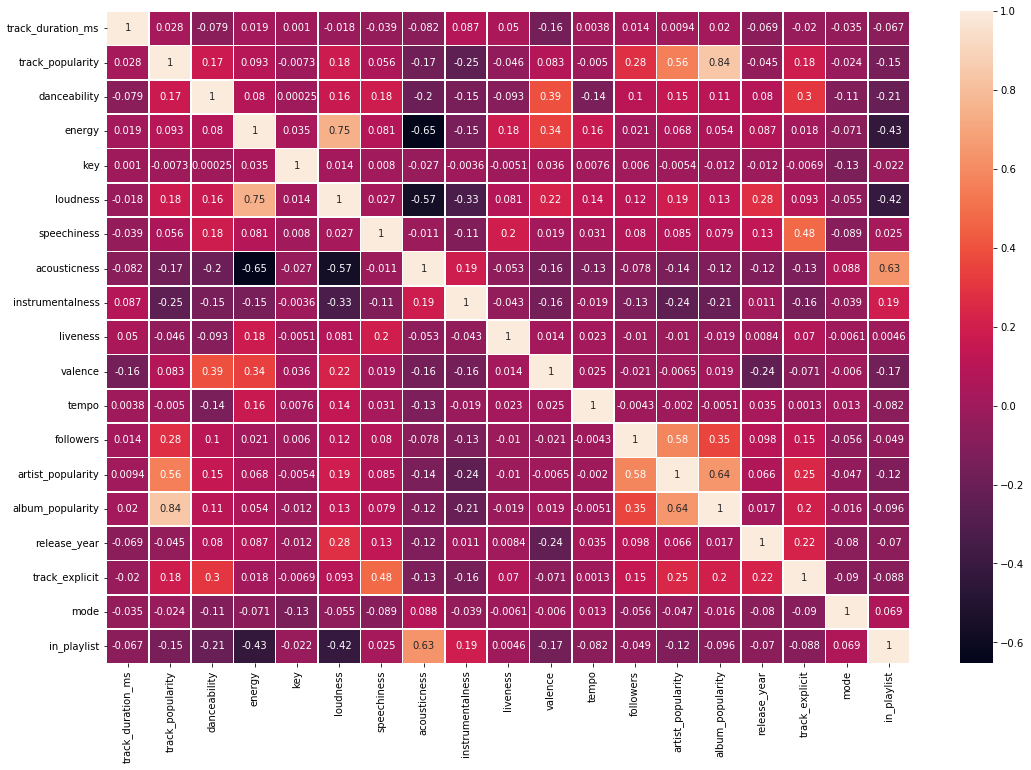

In [55]:
# correlation plot between all predictors
import seaborn as sns

plt.subplots(figsize=(18, 12))
corr = X_database_scaled.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, linewidths=.5,annot=True)

In [56]:
del X_database_scaled['energy']
del X_database_scaled['album_popularity']

indices = np.arange(X_database_scaled.shape[0])
random_indices = np.random.choice(indices, size=20, replace=False)
test_X = X_database_scaled.loc[random_indices]

In [57]:
# here you can see that we accidentally generated new random track IDs, so we had to go back to the lists we provided
# for our subjects and retrieve the right ones...

test_links_1 = ['https://open.spotify.com/track/6OG1S805gIrH5nAQbEOPY3',
'https://open.spotify.com/track/0SGkqnVQo9KPytSri1H6cF',
'https://open.spotify.com/track/3Bp478Itxv8gxqqEcf8HRL',
'https://open.spotify.com/track/7iaw359G2XT14uTfV9feip',
'https://open.spotify.com/track/5qmZHOqnuKopAfKv8W61oN',
'https://open.spotify.com/track/3lBRNqXjPp2j3JMTCXDTNO',
'https://open.spotify.com/track/4uQ7wYsuL0DryknoDc11Hk',
'https://open.spotify.com/track/16qYlQ6koFxYVbiJbGHblz',
'https://open.spotify.com/track/4y5Cc7AOL8CIdtLWdcuGMg',
'https://open.spotify.com/track/7DDRPKLKFIvDbNSQmnz19Y',
'https://open.spotify.com/track/6fZersDfjZ7CMyLe0jvixb',
'https://open.spotify.com/track/22eADXu8DfOAUEDw4vU8qy',
'https://open.spotify.com/track/0lAveUGBd27UoLnhbnSzgG',
'https://open.spotify.com/track/0jn2XqaHliEpWd04ZykIHy',
'https://open.spotify.com/track/6Z8R6UsFuGXGtiIxiD8ISb',
'https://open.spotify.com/track/1XGwjdHXHNu3842f75eg3T',
'https://open.spotify.com/track/6EpRaXYhGOB3fj4V2uDkMJ',
'https://open.spotify.com/track/2lH6RlA7NA2CcTfyEsONTc',
'https://open.spotify.com/track/1SayqEg8HKK2IeIEWjdYxY',
'https://open.spotify.com/track/2fQrGHiQOvpL9UgPvtYy6G',
'https://open.spotify.com/track/0UdWlvyc1Hc97LRX3zAOwC',
'https://open.spotify.com/track/7cb98TMQPLbkE86up3uLz6',
'https://open.spotify.com/track/00xR9dHhuaNznqB4FSzOlr',
'https://open.spotify.com/track/7cjZxxdwK4NLtXyKCTQnNR',
'https://open.spotify.com/track/4MimthDKiYVMCqDBJEiw1U',
'https://open.spotify.com/track/6IEMLVQMHWuqNX50gGdsYB',
'https://open.spotify.com/track/5YzA563GXTuwQaRq24z1k5',
'https://open.spotify.com/track/78WVLOP9pN0G3gRLFy1rAa',
'https://open.spotify.com/track/4Tjh34RS4ACZ6f6srlDBg8',
'https://open.spotify.com/track/24lORMRGMv9sXpZJdN1PVm',
'https://open.spotify.com/track/1oh8AROxt4IUEH42CEFRb9',
'https://open.spotify.com/track/4SKlwyLMGQdzul5S5TvCh5',
'https://open.spotify.com/track/6ngavex4sZrVTif1wwRof0',
'https://open.spotify.com/track/6L2Eoo8Dzx60hARXy7TCic',
'https://open.spotify.com/track/3a1lNhkSLSkpJE4MSHpDu9',
'https://open.spotify.com/track/0aPrTlWUf2nmDkC9gcP5kZ',
'https://open.spotify.com/track/0BBOLOV5JntPL3341swIre',
'https://open.spotify.com/track/2qFIJT5hjqaNFA1GKwl9me',
'https://open.spotify.com/track/7i9HsRBt4punMJWoCoSeu6',]

test_ids = [test_links_1[31:] for test_links_1 in test_links_1]

In [58]:
# we need to get the indices from playlists rather than X_database_scaled because it has information like IDs 
# that aren't being used as predictors, but are obviously crucial for referencing.

test_indices = [] # the indices from 'playlists' that correspond to their assigned random tracks
for ID in test_ids:
    test_indices.append(playlists.track_id[playlists.track_id == ID].index[0]) 

In [59]:
test_y = [8, 7.5, 3, 5, 5, 7.5, 7, 6, 9, 6, 4, 4, 5, 6, 8, 4, 6, 6.5, 5, 8.5]

In [60]:
# a simple linear regression model, no higher orders, trained on 20 songs and ratings 
simple_LR_model = LinearRegression().fit(test_X, test_y)

# predictors and their coefficients
weights = zip(test_X.columns.values, simple_LR_model.coef_)
for weight in weights:
    print(weight)

('track_duration_ms', 0.1681885114666714)
('track_popularity', -3.3676899307052874)
('danceability', 1.455357306622705)
('key', 0.12355053384343508)
('loudness', 0.7442596432008342)
('speechiness', -1.3054053385423134)
('acousticness', -1.2756027174332938)
('instrumentalness', -2.0196016757046045)
('liveness', 0.09497257530110961)
('valence', -1.8282612702489631)
('tempo', -3.186042872838637)
('followers', 0.05522673840101559)
('artist_popularity', 1.2615001622026272)
('release_year', -1.8529048567936748)
('track_explicit', 2.5661431979290454)
('mode', 3.0278872263037213)
('in_playlist', 2.4876492101132244)


In [61]:
# need to drop nan's again - a few were generated during scaling
X_database_scaled = X_database_scaled.dropna(axis=0)
X_database_scaled.shape

(32051, 17)

In [65]:
from sklearn.ensemble import RandomForestRegressor

est_rf = RandomForestRegressor(random_state=15).fit(test_X, test_y)
preds_rf = est_rf.predict(X_database_scaled)

database_rf = X_database_scaled.copy()
database_rf['predicted_ratings'] = preds_rf

database_rf_sorted = database_rf.sort_values(by=['predicted_ratings'])
top5_rf = database_rf_sorted[database_rf_sorted.shape[0]-5:]
top5_rf

,track_duration_ms,track_popularity,danceability,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,followers,artist_popularity,release_year,track_explicit,mode,in_playlist,predicted_ratings
2041,-1.325934,0.034684,-0.475414,0.508743,-1.815793,-0.561337,2.110785,-0.325134,-0.585055,-1.212500,-0.716529,-0.554454,-1.260761,-2.653056,False,1.0,1,8.85
2042,-1.325934,0.034684,-0.475414,0.508743,-1.815793,-0.561337,2.110785,-0.325134,-0.585055,-1.212500,-0.716529,-0.554453,-1.260761,-2.653056,False,1.0,1,8.85
2445,-0.128874,-0.214578,-0.531111,0.508743,-0.800565,-0.568358,1.997618,-0.325152,-0.496159,-1.146524,-0.801837,-0.468303,-0.409328,-0.194102,False,1.0,1,8.85
2043,-1.325934,0.034684,-0.475414,0.508743,-1.815793,-0.561337,2.110785,-0.325134,-0.585055,-1.212500,-0.716529,-0.554453,-1.260761,-2.653056,False,1.0,1,8.85
2040,-1.325934,0.034684,-0.475414,0.508743,-1.815793,-0.561337,2.110785,-0.325134,-0.585055,-1.212500,-0.716529,-0.554454,-1.260761,-2.653056,False,1.0,1,8.85


In [66]:
indices = [index for index in top5_rf.index]
top_ids = playlists.loc[indices].track_id.values
for track_id in top_ids:
    print('https://open.spotify.com/track/{}'.format(track_id))

https://open.spotify.com/track/4QylPpokypCmaiCecvfrIM
https://open.spotify.com/track/4QylPpokypCmaiCecvfrIM
https://open.spotify.com/track/1SOSPCtnLZnfcGKyH8MJn0
https://open.spotify.com/track/4QylPpokypCmaiCecvfrIM
https://open.spotify.com/track/4QylPpokypCmaiCecvfrIM
